### This notebook is used to model sea ice concentration and extent globally, but mostly in the arctic and antarctic regions. The dataset used to look a this information spans from the year 2015 to 2100, and is accompanied by another dataset that can be used to spatially weigh the ice concentration data.
##### Resources in this notebook are largely supplied by Dr. Beadling, and assembled by Colin Krzystek

In [1]:
from matplotlib import pyplot as plt
import matplotlib.path as mpath   ## needed for nice looking polar projections.
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean       
from cartopy import crs as ccrs, feature as cfeature

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### The code in the cell below reads in climate model results stored in the Google Cloud from the GFDL-ESM4 Earth System Model developed at NOAA's Geophysical Fluid Dynamics Laboratory (GFDL). The results are monthly sea ice concentration from the high-emissions future scenario, SSP5-85. A grid cell area file is also loaded in.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
gfdl_esm4_sea_ice_data = df.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'SImon' & \
    variable_id == 'siconc' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn' & \
    member_id == 'r1i1p1f1'"
)

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
# get the path to a specific zarr store (the first one from the dataframe above)
zstore_siconc = gfdl_esm4_sea_ice_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_siconc = gcs.get_mapper(zstore_siconc)
# open the dataset using xarray and zarr
gfdl_esm4_historical_siconc = xr.open_zarr(mapper_siconc, 
                                         consolidated=True,use_cftime=True
                                         ).siconc.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_historical_siconc  #Sea ice model data

<xarray.DataArray 'siconc' (time: 1032, latitude: 576, longitude: 720)>
dask.array<open_dataset-siconc, shape=(1032, 576, 720), dtype=float32, chunksize=(600, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Ice Area Fraction (Ocean Grid)
    original_name:  siconc
    standard_name:  sea_ice_area_fraction
    units:          %

In [5]:
gfdl_esm4_cell_area_data = df.query(
    "activity_id=='CMIP' & \
    table_id == 'Ofx' & \
    variable_id == 'areacello' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_area = gfdl_esm4_cell_area_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_area = gcs.get_mapper(zstore_area)
# open the dataset using xarray and zarr
gfdl_esm4_cell_area = xr.open_zarr(mapper_area, 
                                         consolidated=True,
                                         ).areacello.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_cell_area #Sea ice model grid cell area

<xarray.DataArray 'areacello' (latitude: 576, longitude: 720)>
dask.array<open_dataset-areacello, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_methods:   area: sum
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m2

### In the cells below present an analysis of Arctic and Antarctic sea ice extent comparing the start of the 21st century (years 2014 to 2025 average) to the end (years 2081 to 2100). Describe your results below. In addition to presenting an effective visualization, your results must be quantitative.

Text(0.5, 25.722222222222214, 'Longitude')

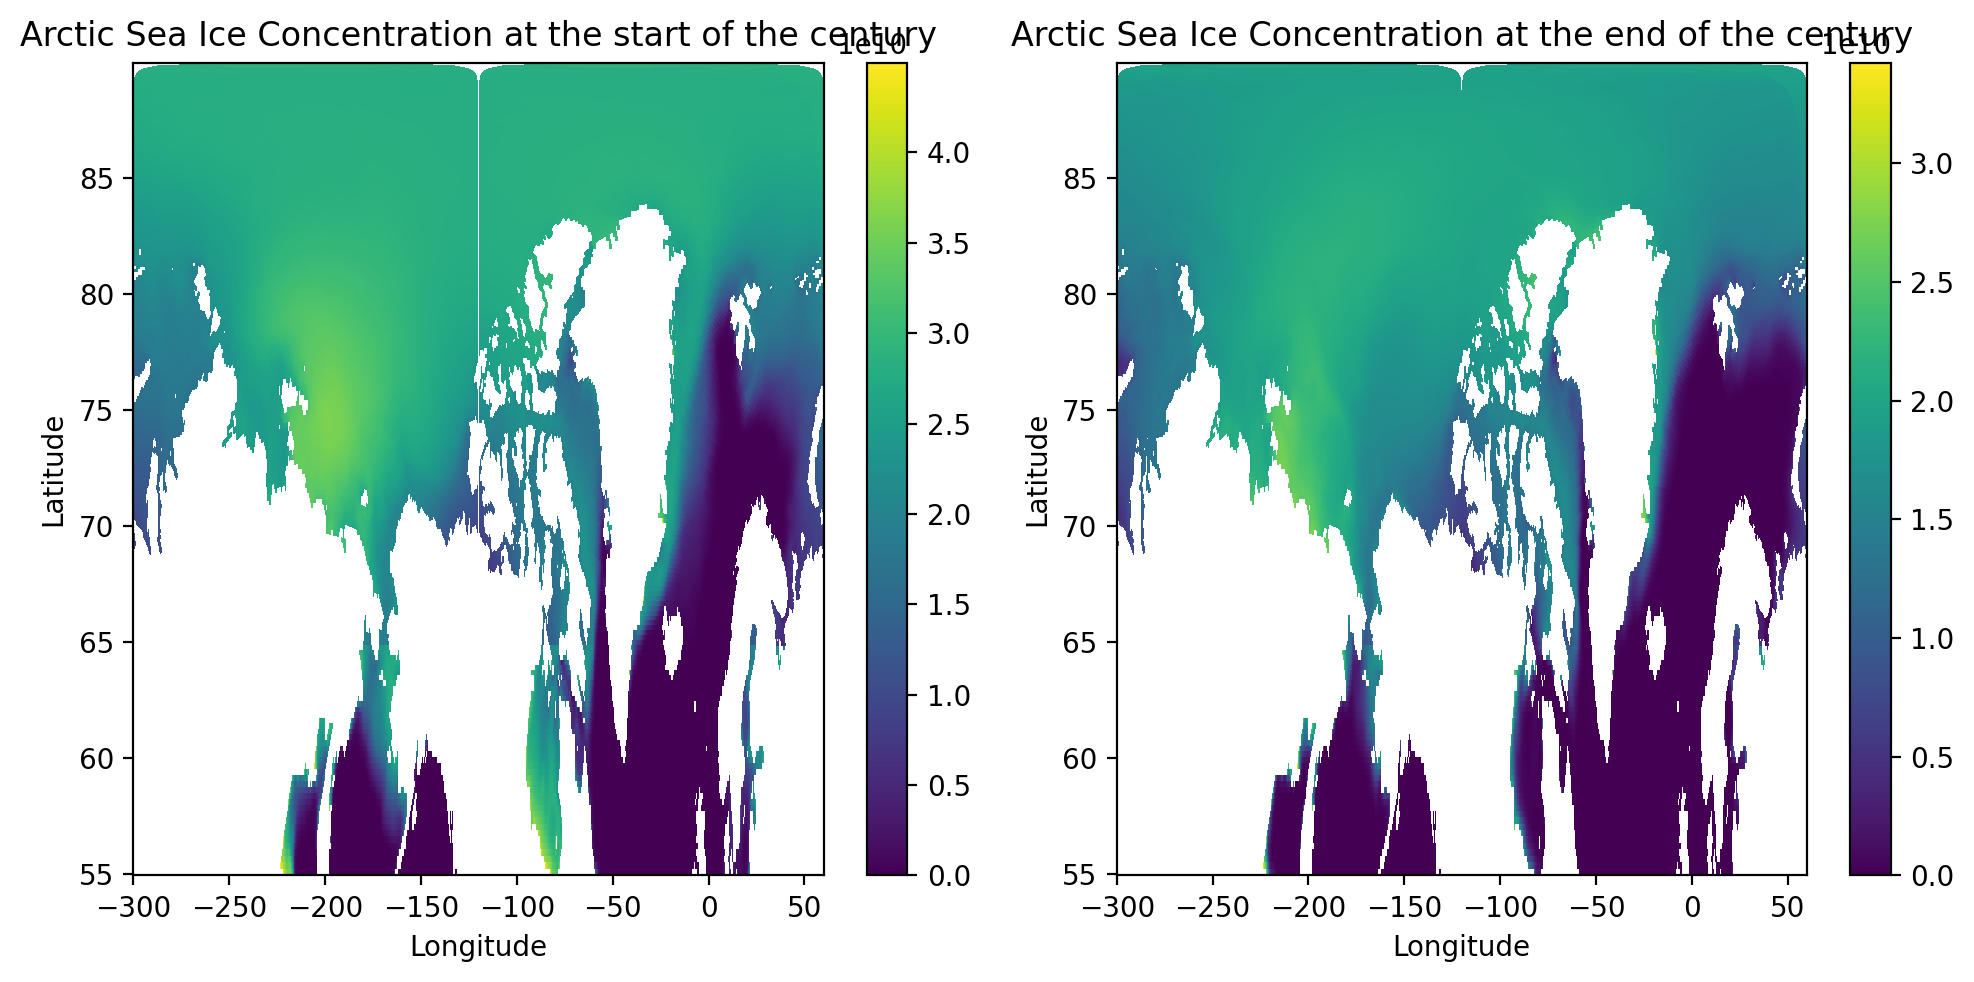

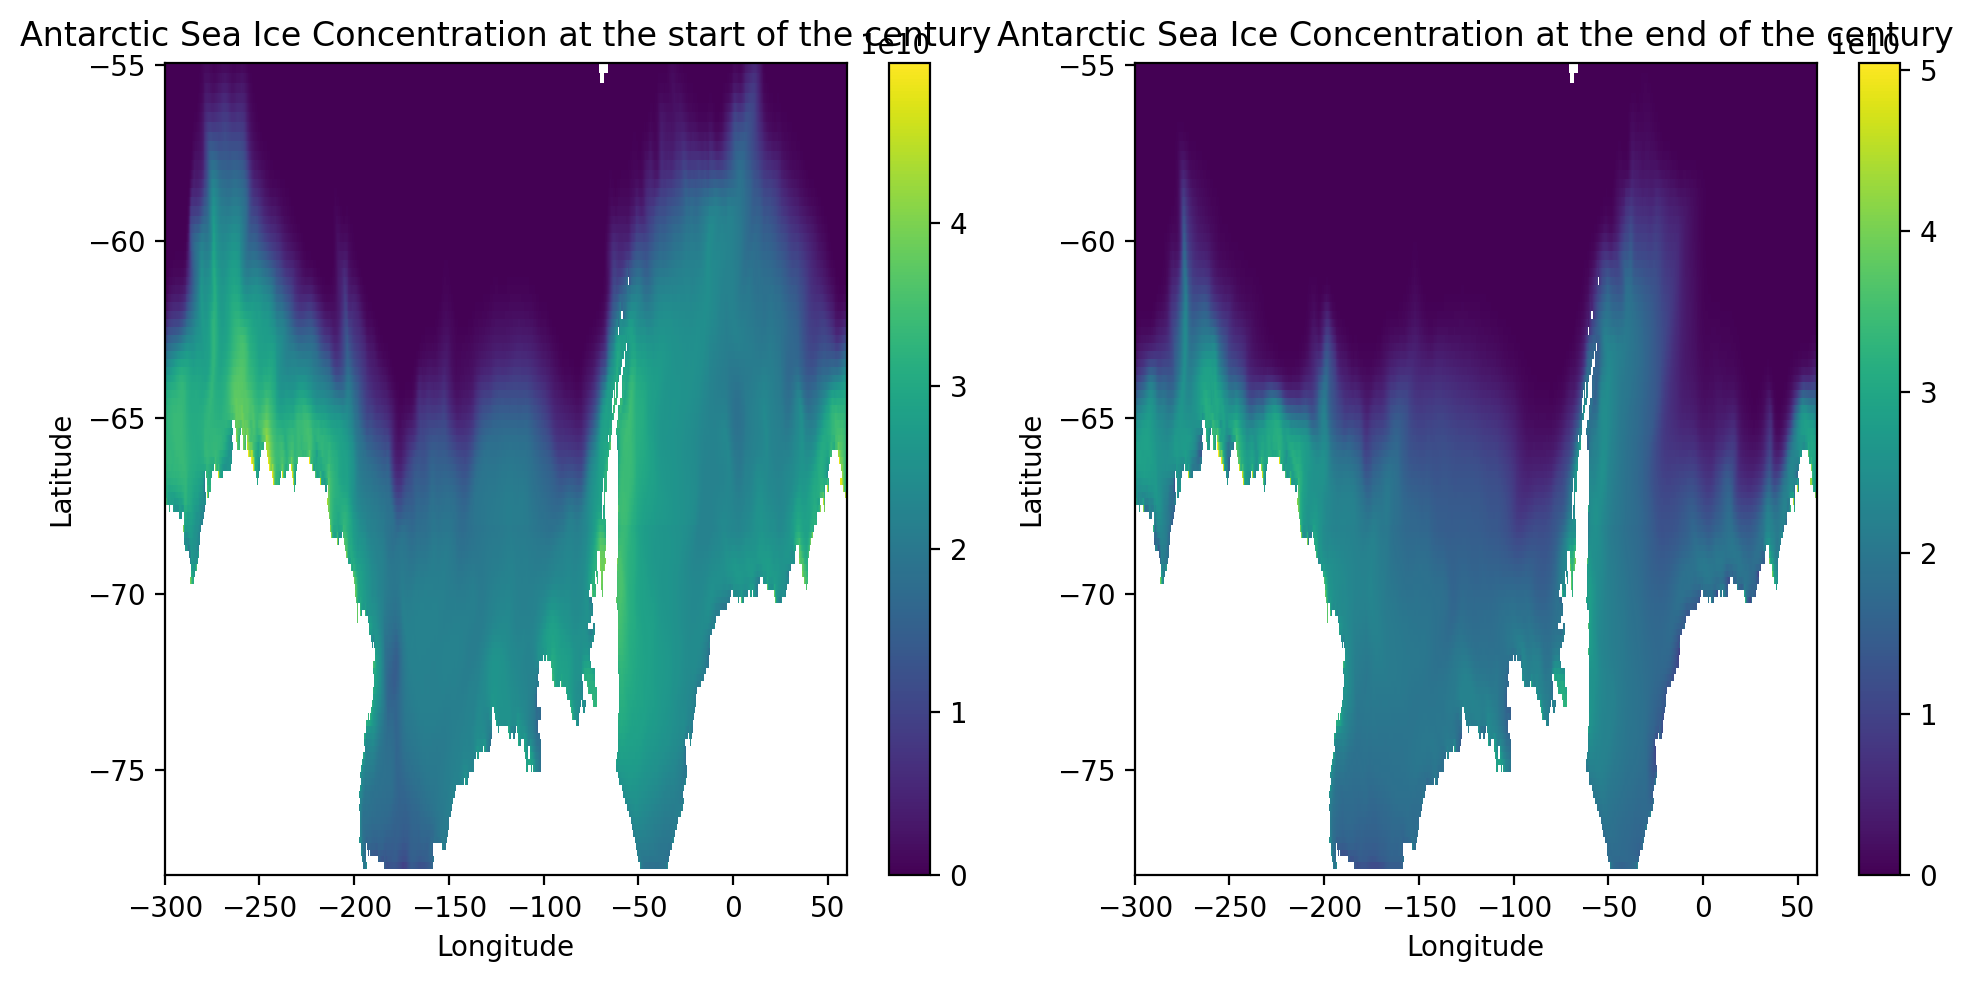

In [6]:
end = gfdl_esm4_historical_siconc.sel(time=slice('2081-01-01','2100-12-01'))   #slicing out the end years of the model
start= gfdl_esm4_historical_siconc.sel(time=slice('2014-01-01','2024-12-01'))  #slicing out the start years of the model

end_annual = ml.util.annual_cycle(end,tcoord='time')    #Averaging over each month
start_annual = ml.util.annual_cycle(start,tcoord='time') #Averaging over each month
end_average = ml.util.annual_average(end_annual,tcoord='time').squeeze()  #Averaging over each year
start_average = ml.util.annual_average(start_annual,tcoord='time').squeeze()  #Averaging over each year
start_average = start_average*gfdl_esm4_cell_area
end_average = end_average*gfdl_esm4_cell_area

arctic_start = start_average.sel(latitude=slice(55,90))  #slicing out the arctic region
arctic_end = end_average.sel(latitude=slice(55,90))  #slicing out the arctic region
antarctic_start = start_average.sel(latitude=slice(-90,-55))  #slicing out the antarctic region
antarctic_end = end_average.sel(latitude=slice(-90,-55))  #slicing out the antarctic region

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize =(10,5))  #plotting the time averaged sea ice concentration in the arctic

arctic_start.plot( ax=ax0, x='geolon', y='geolat')
arctic_end.plot( ax=ax1, x='geolon', y='geolat')
plt.tight_layout()
ax0.set_title('Arctic Sea Ice Concentration at the start of the century')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax1.set_title('Arctic Sea Ice Concentration at the end of the century')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize =(10,5))  #plotting the time averaged sea ice concentration in the antarctic

antarctic_start.plot( ax=ax0, x='geolon', y='geolat')
antarctic_end.plot( ax=ax1, x='geolon', y='geolat')
plt.tight_layout()
ax0.set_title('Antarctic Sea Ice Concentration at the start of the century')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax1.set_title('Antarctic Sea Ice Concentration at the end of the century')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

**Figure 1:** Arctic and Antarctic sea ice extent comparing the start of the 21st century (years 2014 to 2025 average) to the end (years 2081 to 2100). The top two charts are the arctic region and the bottom two charts are the antarctic region. The left two charts represent those regions at the start of the 21st century, while the right two charts represent those regions at the end of the 21st century. These charts were produced using the sea ice concentration model dataset and spatially weighed using the sea ice grid cell model data.

### Compute and produce a timeseries of the Arctic and Antarctic annual mean SIE from 2014 to 2100.

#### Note that due to a bug in Xarray dealing with a NOLEAP calendar, you must convert the calendar to Gregorian prior to plotting ....

#### `data_array.convert_calendar('Gregorian').plot()`

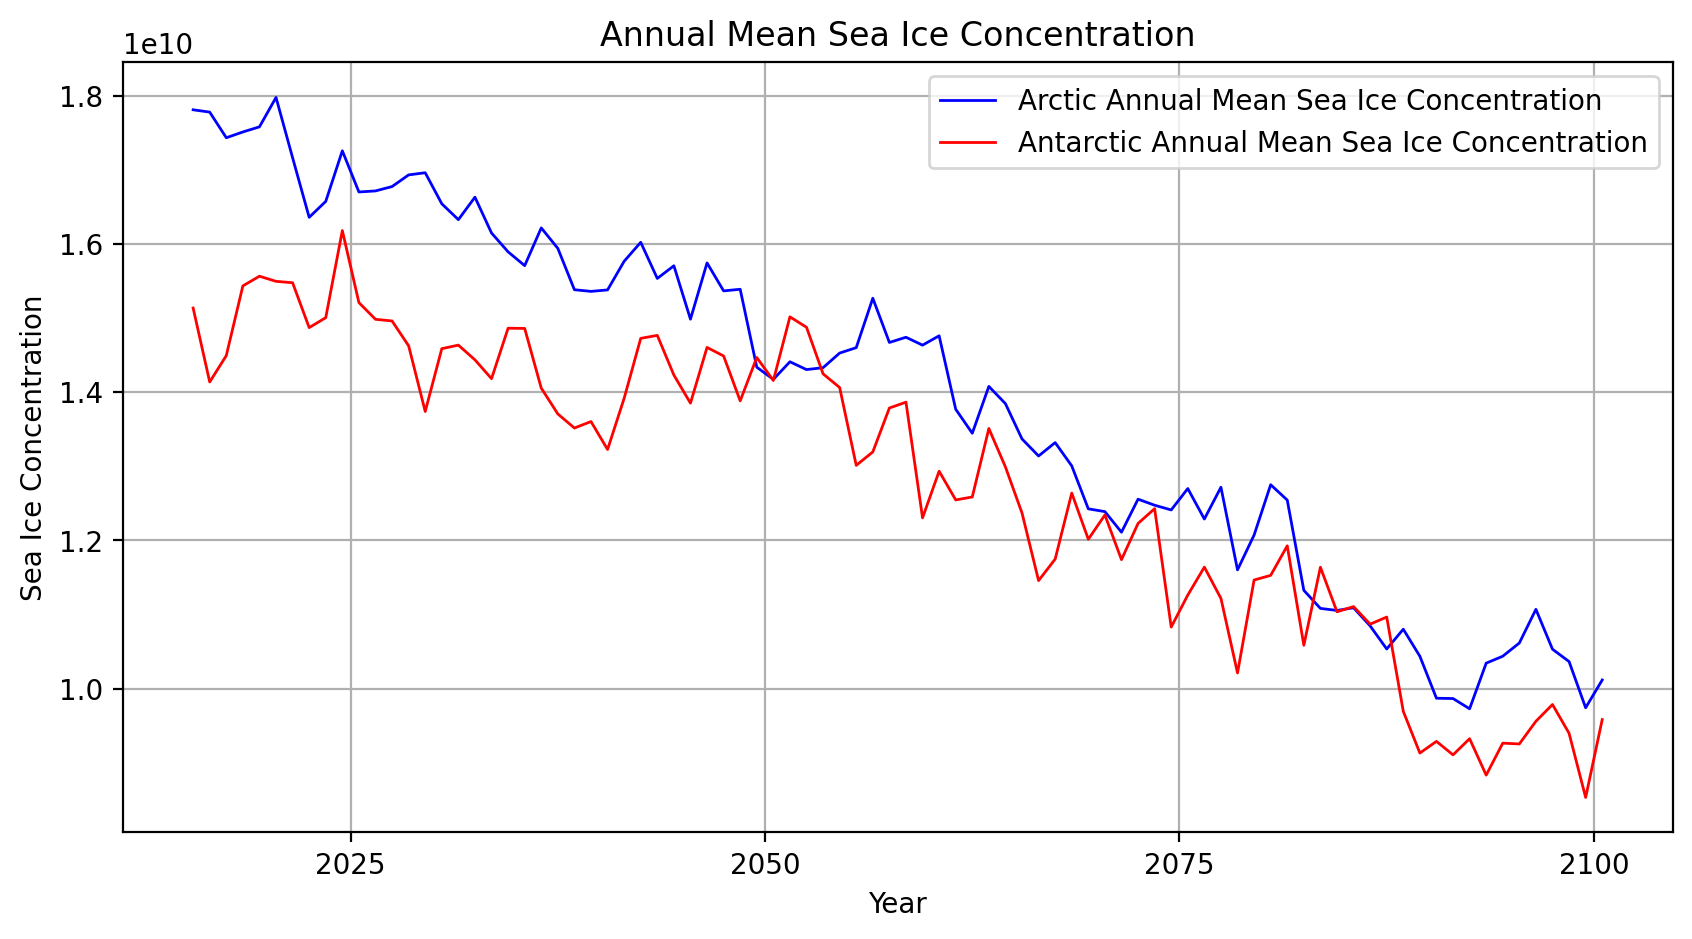

In [7]:
arctic = gfdl_esm4_historical_siconc.sel(latitude=slice(55,90)) #.mean(dim=['latitude','longitude'])   #Slicing out the arctic region
ant = gfdl_esm4_historical_siconc.sel(latitude=slice(-90,-55)) #.mean(dim=['latitude','longitude'])    #slicing out the antarctic region

grid_arctic = ((gfdl_esm4_cell_area*gfdl_esm4_historical_siconc).sel(latitude=slice(55,90)).mean(dim=['latitude','longitude']))  #Spatially weighting the arctic region
grid_ant = ((gfdl_esm4_cell_area*gfdl_esm4_historical_siconc).sel(latitude=slice(-90,-55)).mean(dim=['latitude','longitude']))  #Spatially weighting the antarctic region
grid_arctic_average = ml.util.annual_average(grid_arctic,tcoord='time')   #Averaging over each year from 2014-2100 in the arctic
grid_antarctic_average = ml.util.annual_average(grid_ant,tcoord='time')   #Averaging over each year from 2014-2100 in the antarctic
#grid_arctic_average.convert_calendar('Gregorian').plot()  #Plotting the Arctic annual mean sea ice concentration from 2014-2100

fig, ax = plt.subplots(figsize = (10, 5))
grid_arctic_average.plot(ax=ax,
        linewidth=1,label='Arctic Annual Mean Sea Ice Concentration',
        color='blue')
grid_antarctic_average.plot(ax=ax,
        linewidth=1,label='Antarctic Annual Mean Sea Ice Concentration',
        color='red')

ax.set_title('Annual Mean Sea Ice Concentration')
## add axes labes:
ax.set_ylabel('Sea Ice Concentration')
ax.set_xlabel('Year')

ax.grid(linestyle='-')
ax.legend()

**Figure 2:** Timeseries of the Arctic and Antarctic annual mean SIE from 2014 to 2100, using the sea ice concentration model data set and spatially weighed by the sea ice grid cell model data.

### Produce effective visualizations of the spatial changes in Arctic and Antarctic sea ice concentration at the end of the century vs. the start. Describe the patterns in the cell below. Note that the North Pole looks distorted in the model data .... this is because climate models actually have 3 poles .... a "tri-polar" grid, due to computational difficulties with solving equations converging on a single point.

### Read the following tutorial and work through the use of `geolon` and `geolat` in the `.plot()` method to produce the correct non-distorted Antarctic.

### All differences should be computed as `last - first`.

Text(0.5, 25.722222222222214, 'Longitude')

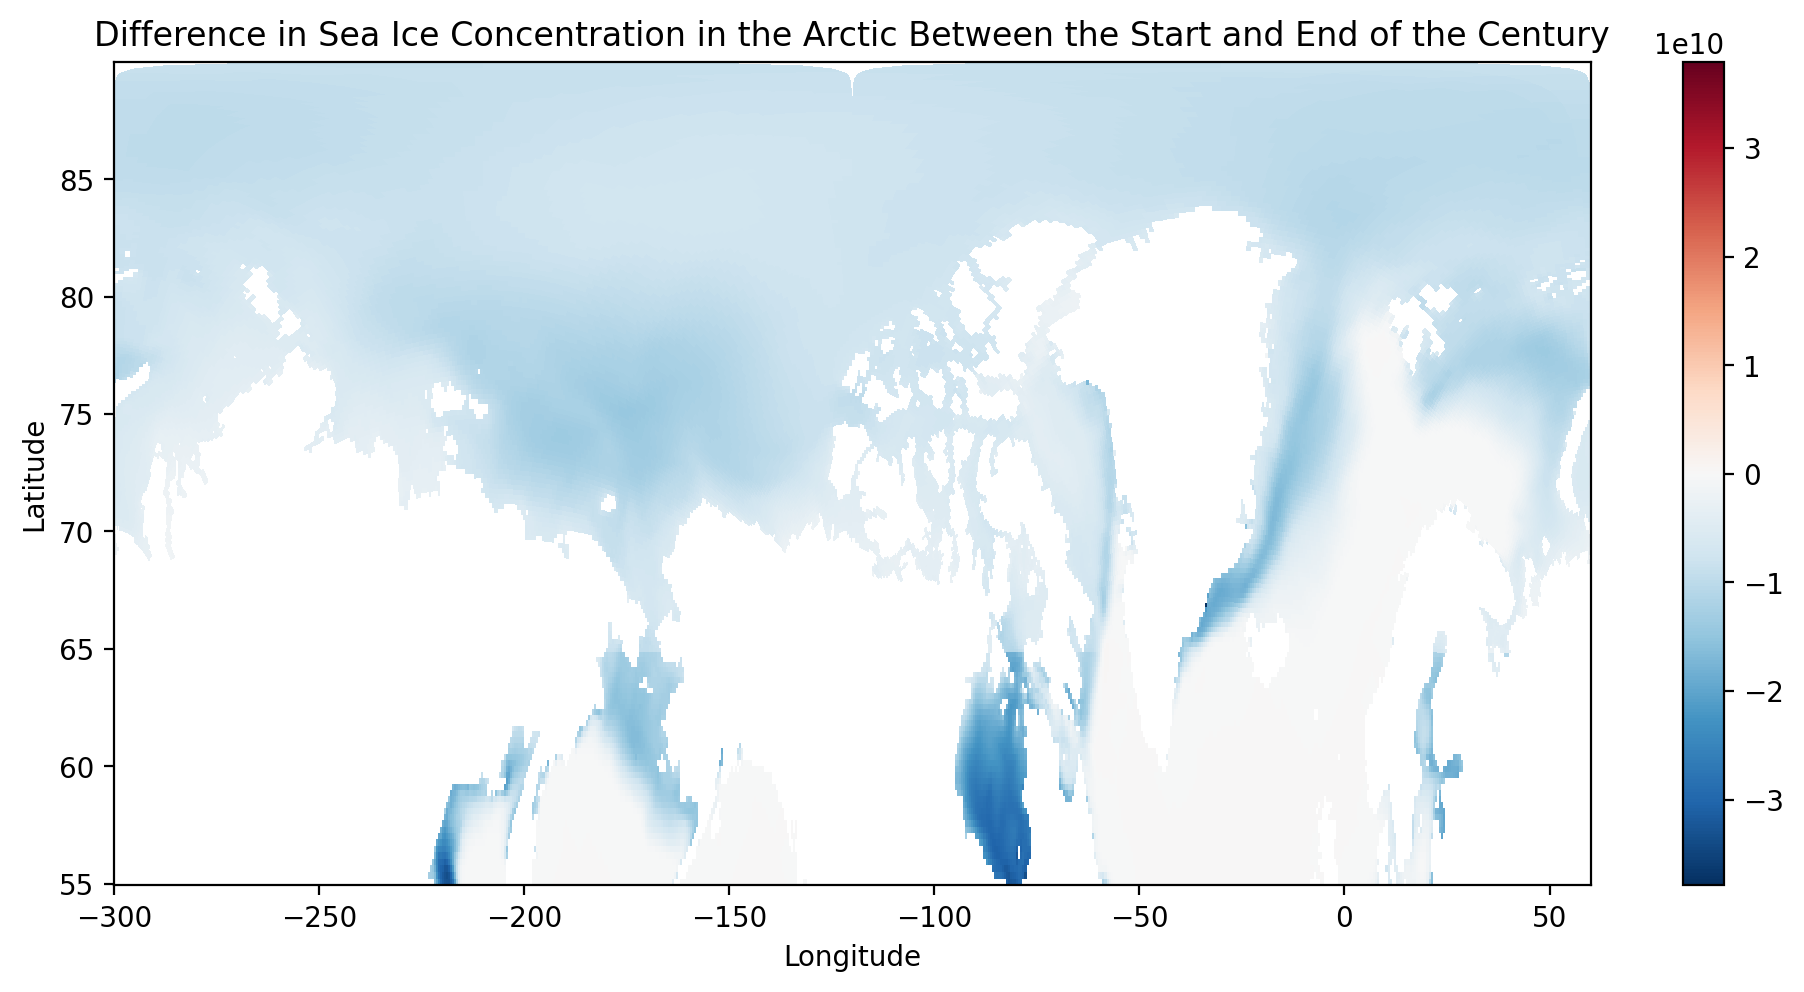

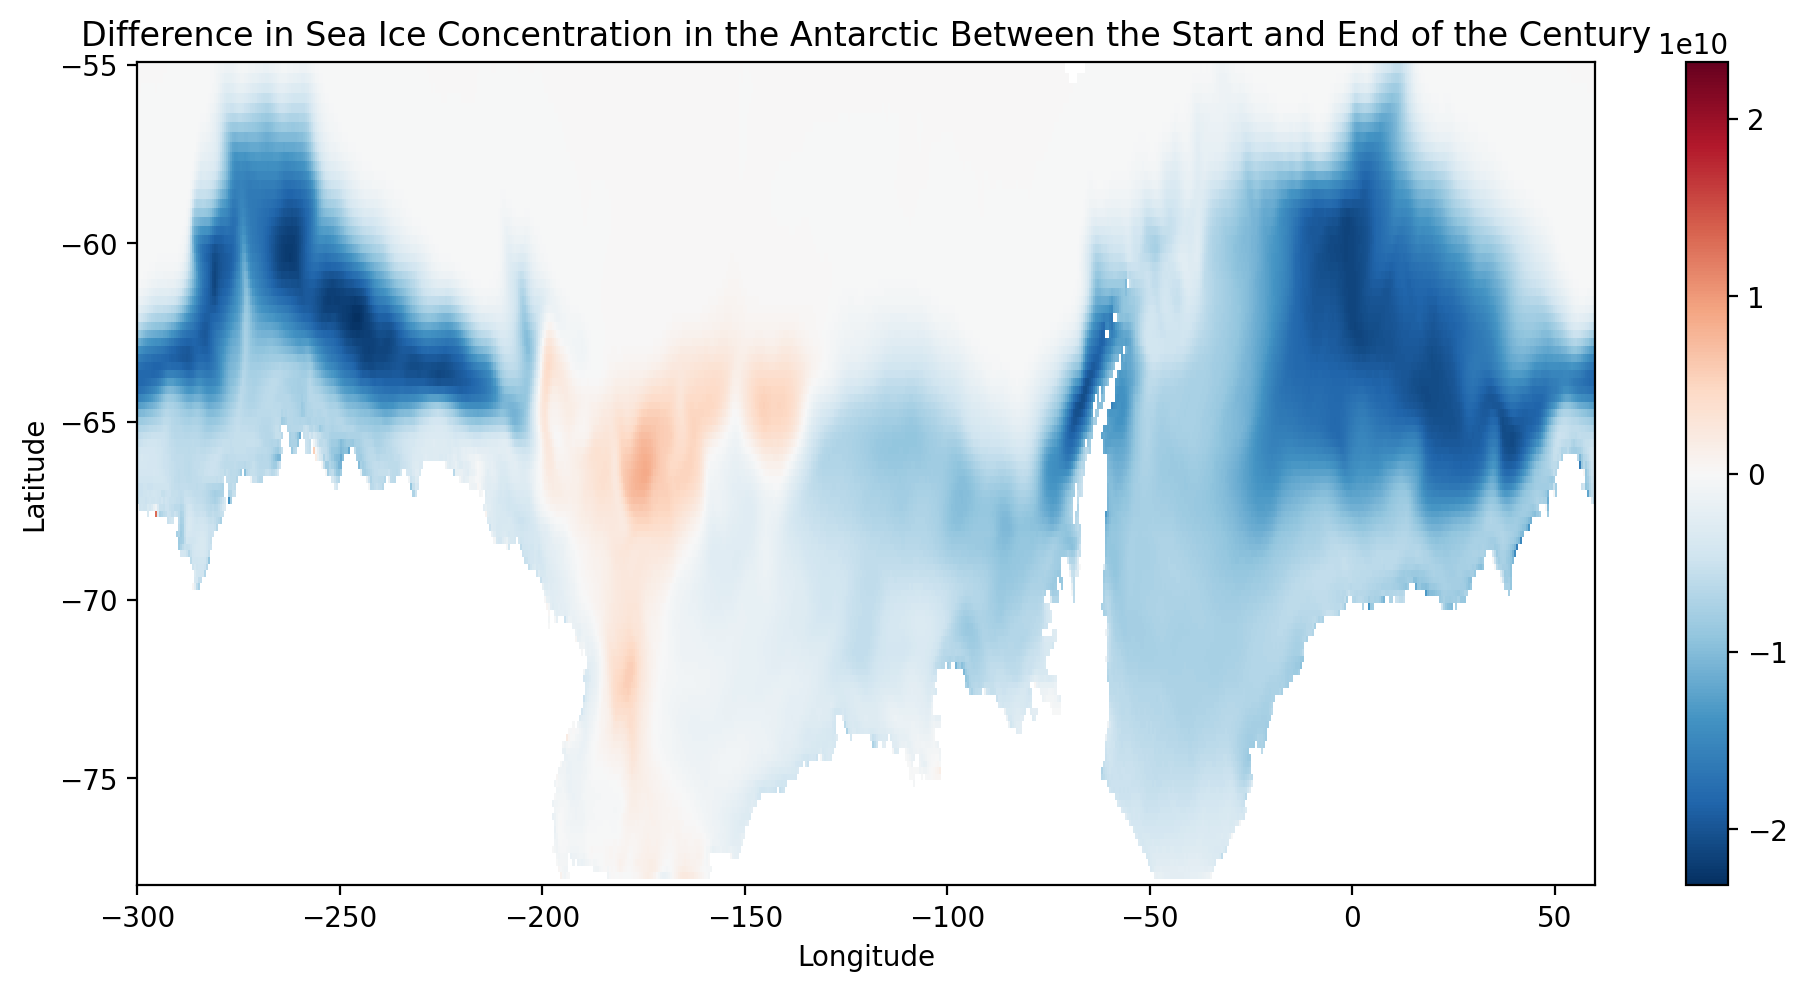

In [9]:
gfdl_esm4_cell_area = gfdl_esm4_cell_area.assign_coords({'geolon': gfdl_esm4_cell_area['geolon'],
                       'geolat': gfdl_esm4_cell_area['geolat']})

end = gfdl_esm4_historical_siconc.sel(time=slice('2081-01-01','2100-12-01'))   #slicing out the end years of the model
start= gfdl_esm4_historical_siconc.sel(time=slice('2014-01-01','2024-12-01'))  #slicing out the start years of the model

end_annual = ml.util.annual_cycle(end,tcoord='time')    #Averaging over each month
start_annual = ml.util.annual_cycle(start,tcoord='time') #Averaging over each month
end_average = ml.util.annual_average(end_annual,tcoord='time').squeeze()  #Averaging over each year
start_average = ml.util.annual_average(start_annual,tcoord='time').squeeze()  #Averaging over each year
start_average = start_average*gfdl_esm4_cell_area
end_average = end_average*gfdl_esm4_cell_area

Difference = end_average - start_average
Difference1 = Difference.sel(latitude=slice(55,90))
Difference2 = Difference.sel(latitude=slice(-90,-55))

fig, ax = plt.subplots(figsize =(10,5))  #plotting the time averaged sea ice concentration om the arctic

Difference1.plot( ax=ax, x='geolon', y='geolat')
plt.tight_layout()
ax.set_title('Difference in Sea Ice Concentration in the Arctic Between the Start and End of the Century')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig, ax = plt.subplots(figsize =(10,5))  #plotting the time averaged sea ice concentration in the antarctic

Difference2.plot( ax=ax, x='geolon', y='geolat')
plt.tight_layout()
ax.set_title('Difference in Sea Ice Concentration in the Antarctic Between the Start and End of the Century')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

**Figure 3:** Charts representing the difference in SIE in the polar regions between the start and end of the 21st century. The top chart is the difference in the arctic region while the bottom chart is the difference in the antarctic region. These charts were produced using the sea ice concentration model dataset and spatially weighed using the sea ice grid cell model data.

After analyzing the data sets provided and creating several figures to help examine the effects of climate change on SIE, a few things have been made clear. It is evident that SIE changes on a season to season basis, as well as a month to month basis, however in the longrun SIE will likely continue to decrease over the rest of the century and potentially beyond. While there may be a small area in the antarctic that is still expected to grow slightly for the most part SIE will decrease drastically by the end of the century in the rest of the polar regions.